# Importing Libraries

In [39]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Point
import geoplot.crs as gcrs
import contextily as cx

- The link where the data was downloaded is: http://insideairbnb.com/get-the-data/. 
- This dataset is specifically the listings in NYC. 
- The data columns can be explained when clicking on this link https://docs.google.com/spreadsheets/d/1iWCNJcSutYqpULSQHlNyGInUvHg2BoUGoNRIGa6Szc4/edit?usp=sharing. 
- Data used in this project was scraped on December 15, 2022.

# Loading and Preparing Datasets

In [40]:
# Kept the original dataset
listingsNYC = pd.read_csv('listings.csv', dtype=object)

# Dropping all of the columns which we will not use
listingsNYC= listingsNYC.drop(['last_review','license','host_name'], axis=1)

# Dropping all rows with any 'Nan' values in them
listingsNYC.dropna(axis=0, how='any', inplace=True)
data_types_dict = {
    'price':'int64', 
    'minimum_nights':'int64', 
    'host_id':str,
    'number_of_reviews':'int64',
    'reviews_per_month':float,
    'calculated_host_listings_count':'int64',
    'availability_365':'int64',
    'number_of_reviews_ltm':'int64',
    'latitude':float,
    'longitude':float,
    
}

#changing all the datatype to their respective types that we can work with
listingsNYC = listingsNYC.astype(data_types_dict)

# creating a price per stay (ppn) column with the price and minimim nights columns and rounding to 2 decimal places. 
# This is a float dtype 
listingsNYC['pps'] = (listingsNYC['price'] * listingsNYC['minimum_nights']).round(2)
listingsNYC['neighbourhood'].unique().shape[0]
listingsNYC

,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,21,3,0.03,1,267,1,5775
1,5203,Cozy Clean Guest Room - Family Apt,7490,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,2,118,0.73,1,0,0,150
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,40.685350,-73.955120,Private room,60,30,50,0.30,2,322,0,1800
3,5178,Large Furnished Room Near B'way,8967,Manhattan,Midtown,40.764570,-73.983170,Private room,68,2,559,3.38,1,79,50,136
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.753560,-73.985590,Entire home/apt,175,30,49,0.31,3,365,1,5250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,769580756557673403,Cozy 1 bedroom with 2 full beds ROOM #2,162927656,Queens,Jamaica,40.693422,-73.804985,Shared room,99,1,1,1.00,7,174,1,99
41160,769612968972941927,Comfortable 1 bedroom ROOM #3,162927656,Queens,Jamaica,40.691520,-73.805300,Shared room,91,1,1,1.00,7,174,1,91
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,40.666019,-73.857968,Entire home/apt,145,1,2,2.00,1,351,2,145
41218,769850569510129629,Private Bed Manhattan 20 Mins,324722741,Queens,Woodside,40.746040,-73.909110,Private room,50,1,1,1.00,1,240,1,50


### Removing Outliers

In [41]:
# check for outliers 
describe_df = listingsNYC.describe()
describe_df

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps
count,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,32134.000000,3.213400e+04
mean,40.726887,-73.942745,196.275223,16.139354,33.867866,1.279502,10.636958,142.513506,10.318883,2.685699e+03
std,0.058226,0.056939,831.541622,28.483042,61.803678,1.935213,38.325794,141.416457,20.526149,1.573199e+04
min,40.500314,-74.249840,0.000000,1.000000,1.000000,0.010000,1.000000,0.000000,0.000000,0.000000e+00
25%,40.686020,-73.981290,80.000000,2.000000,3.000000,0.140000,1.000000,0.000000,0.000000,2.980000e+02
50%,40.721565,-73.951545,130.000000,5.000000,10.000000,0.580000,1.000000,89.000000,2.000000,1.028000e+03
75%,40.762260,-73.923150,208.000000,30.000000,36.000000,1.880000,3.000000,306.000000,13.000000,3.000000e+03
max,40.910620,-73.710870,98159.000000,1250.000000,1666.000000,102.980000,487.000000,365.000000,992.000000,2.253600e+06


### Dropping rows with a price or pps of 0

In [42]:
listingsNYC = listingsNYC[(listingsNYC['price'] != 0)]
listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])
listingsNYC

C:\Users\Roger\AppData\Local\Temp\ipykernel_17892\2536111161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  listingsNYC.loc[:,'log_price']=np.log(listingsNYC['price'])


,id,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,pps,log_price
0,5136,"Spacious Brooklyn Duplex, Patio + Garden",7378,Brooklyn,Sunset Park,40.662650,-73.994540,Entire home/apt,275,21,3,0.03,1,267,1,5775,5.616771
1,5203,Cozy Clean Guest Room - Family Apt,7490,Manhattan,Upper West Side,40.803800,-73.967510,Private room,75,2,118,0.73,1,0,0,150,4.317488
2,5121,BlissArtsSpace!,7356,Brooklyn,Bedford-Stuyvesant,40.685350,-73.955120,Private room,60,30,50,0.30,2,322,0,1800,4.094345
3,5178,Large Furnished Room Near B'way,8967,Manhattan,Midtown,40.764570,-73.983170,Private room,68,2,559,3.38,1,79,50,136,4.219508
4,2595,Skylit Midtown Castle,2845,Manhattan,Midtown,40.753560,-73.985590,Entire home/apt,175,30,49,0.31,3,365,1,5250,5.164786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41139,769580756557673403,Cozy 1 bedroom with 2 full beds ROOM #2,162927656,Queens,Jamaica,40.693422,-73.804985,Shared room,99,1,1,1.00,7,174,1,99,4.595120
41160,769612968972941927,Comfortable 1 bedroom ROOM #3,162927656,Queens,Jamaica,40.691520,-73.805300,Shared room,91,1,1,1.00,7,174,1,91,4.510860
41175,770593748958588679,Luxury Brooklyn apt. | 10 mins away from JFK,489532090,Brooklyn,East New York,40.666019,-73.857968,Entire home/apt,145,1,2,2.00,1,351,2,145,4.976734
41218,769850569510129629,Private Bed Manhattan 20 Mins,324722741,Queens,Woodside,40.746040,-73.909110,Private room,50,1,1,1.00,1,240,1,50,3.912023


# Visualizations

In [43]:
neighborhood_counts = listingsNYC.groupby('neighbourhood').count()
neighborhood_counts=neighborhood_counts[['id']]
neighborhood_counts.rename(columns={'id':'neighborhood_count'}, inplace=True)
neighborhood_counts

,neighborhood_count
neighbourhood,
Allerton,45
Arden Heights,4
Arrochar,17
Arverne,109
Astoria,601
...,...
Windsor Terrace,100
Woodhaven,85
Woodlawn,9


In [44]:
neighborhood_means = listingsNYC.groupby('neighbourhood').mean()
neighborhood_means=neighborhood_means[['latitude','longitude','price']]
neighborhood_means

,latitude,longitude,price
neighbourhood,,,
Allerton,40.864974,-73.858897,112.244444
Arden Heights,40.551897,-74.175929,134.250000
Arrochar,40.592589,-74.071510,132.117647
Arverne,40.592835,-73.795136,191.330275
Astoria,40.764937,-73.920717,123.608985
...,...,...,...
Windsor Terrace,40.655011,-73.978425,161.530000
Woodhaven,40.691838,-73.859079,91.776471
Woodlawn,40.898721,-73.866208,129.333333


In [45]:
neighborhood_means_and_counts= pd.merge(neighborhood_counts,neighborhood_means, on='neighbourhood')
neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False).head(20)

,neighborhood_count,latitude,longitude,price
neighbourhood,,,,
Bedford-Stuyvesant,2371,40.686829,-73.938112,188.759173
Williamsburg,2067,40.712410,-73.951810,184.217223
Harlem,1594,40.815248,-73.947828,148.417189
Bushwick,1349,40.695944,-73.920009,119.297999
Midtown,1188,40.753467,-73.978756,386.317340
Hell's Kitchen,1103,40.761411,-73.992245,285.331822
Upper West Side,1078,40.789498,-73.972486,221.560297
Upper East Side,1061,40.772676,-73.955003,214.010368
Crown Heights,1051,40.673057,-73.943545,152.588011


In [56]:
nyc_map = gpd.read_file("neighbourhoods.geojson")
nyc_map

,neighbourhood,neighbourhood_group,geometry
0,Bayswater,Queens,"MULTIPOLYGON (((-73.76671 40.61491, -73.76825 ..."
1,Allerton,Bronx,"MULTIPOLYGON (((-73.84860 40.87167, -73.84582 ..."
2,City Island,Bronx,"MULTIPOLYGON (((-73.78282 40.84392, -73.78257 ..."
3,Ditmars Steinway,Queens,"MULTIPOLYGON (((-73.90160 40.76777, -73.90391 ..."
4,Ozone Park,Queens,"MULTIPOLYGON (((-73.83754 40.69136, -73.83108 ..."
...,...,...,...
228,Westchester Square,Bronx,"MULTIPOLYGON (((-73.84294 40.84640, -73.83913 ..."
229,Westerleigh,Staten Island,"MULTIPOLYGON (((-74.13131 40.62633, -74.13192 ..."
230,Williamsbridge,Bronx,"MULTIPOLYGON (((-73.86722 40.86969, -73.86701 ..."
231,Williamsburg,Brooklyn,"MULTIPOLYGON (((-73.95757 40.72510, -73.95300 ..."


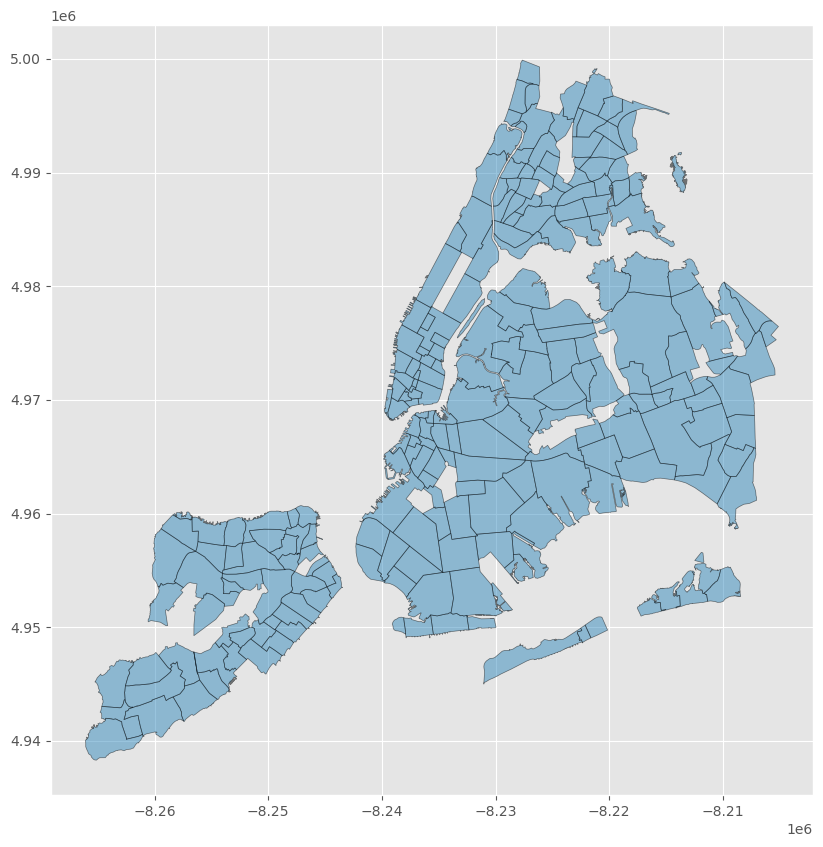

In [57]:
ax = nyc_bubble_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')

In [48]:
nyc_bubble_map.to_crs(epsg=3857, inplace=True)
nyc_bubble_map.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [49]:
points = []
for lon, lat in zip(neighborhood_means_and_counts["longitude"], neighborhood_means_and_counts["latitude"]):
    points.append(Point(lon, lat))

neighborhood_means_and_counts["geometry"] = points

neighborhood_means_and_counts = gpd.GeoDataFrame(neighborhood_means_and_counts)

neighborhood_means_and_counts.head()
neighborhood_means_and_counts.crs = "EPSG:3857"
neighborhood_means_and_counts.crs

C:\Users\Roger\anaconda3\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
ax = gplt.kdeplot(
    collisions.head(1000), clip=df_geo.geometry,
    shade=True, cmap='Reds',
    projection=geoplot.crs.AlbersEqualArea())
gplt.polyplot(df_geo, ax=ax, zorder=1)

In [50]:
type(neighborhood_means_and_counts)

geopandas.geodataframe.GeoDataFrame

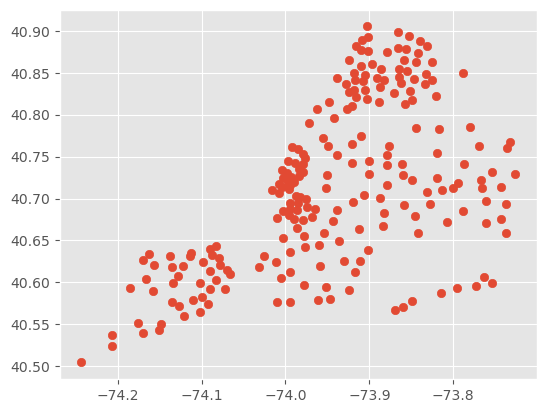

In [51]:
ax = neighborhood_means_and_counts.plot()

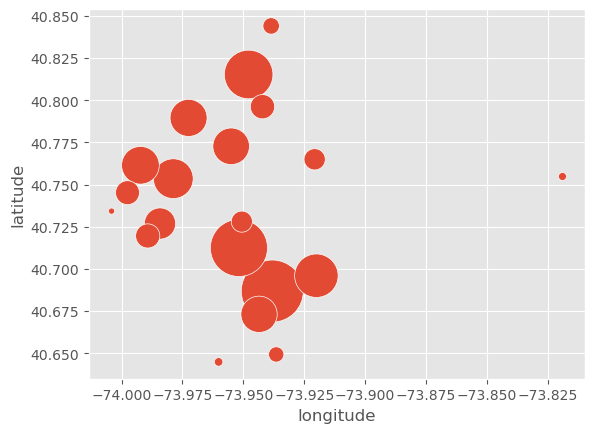

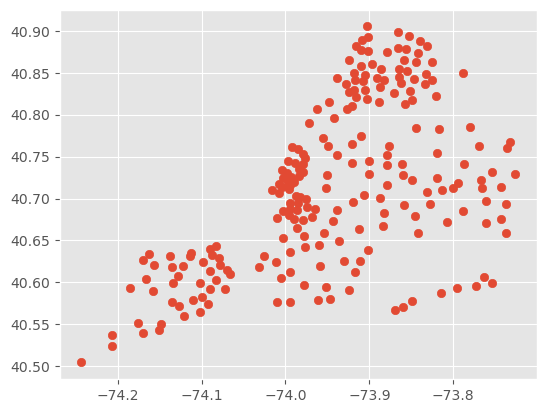

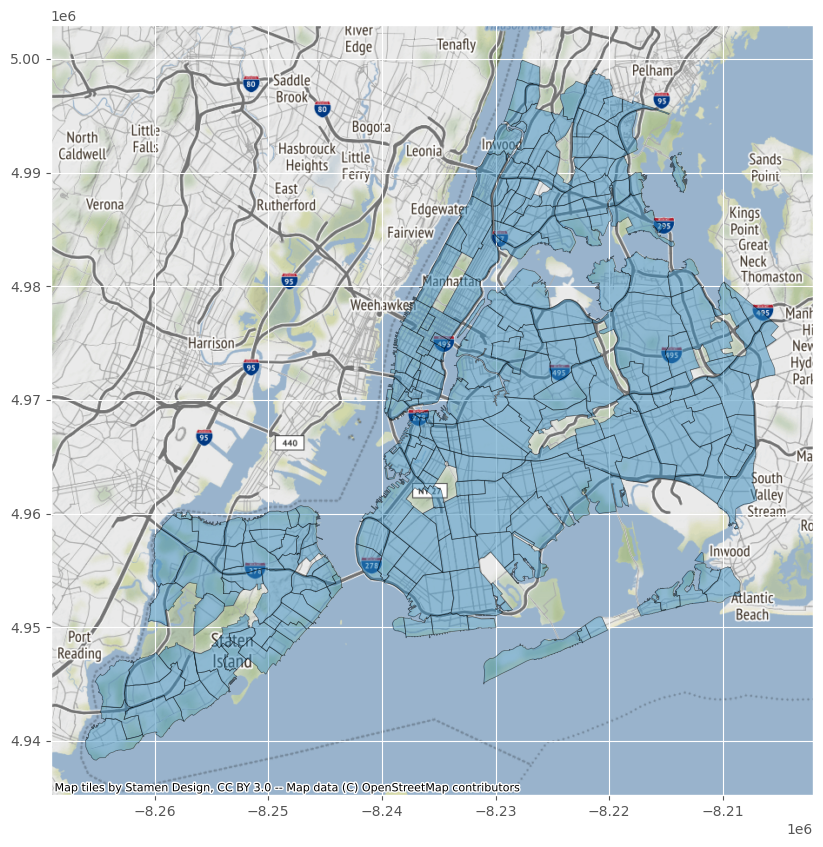

In [61]:
# fig, ax = plt.subplots(figsize=(16,16))

# neighborhood_means_and_counts.plot(ax=ax, column="Age_80_norm", cmap="Blues",edgecolor="grey", linewidth=0.4, legend=True)
# ax.axis("off")
# plt.axis('equal')
sns.scatterplot(data=neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False).head(20), x="longitude", y="latitude", size="neighborhood_count", legend=False, sizes=(20, 2000))
# ax = nyc_bubble_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
neighborhood_means_and_counts.plot()
ax = nyc_bubble_map.plot(figsize=(10, 10), alpha=0.5, edgecolor='k')
cx.add_basemap(ax)

plt.show()

In [62]:
nyc_bubble_map.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

C:\Users\Roger\anaconda3\lib\site-packages\geoplot\geoplot.py:248: UserWarning: Please specify "legend_var" explicitly when both "hue" and "scale" are specified. Defaulting to "legend_var='hue'".
  warnings.warn(


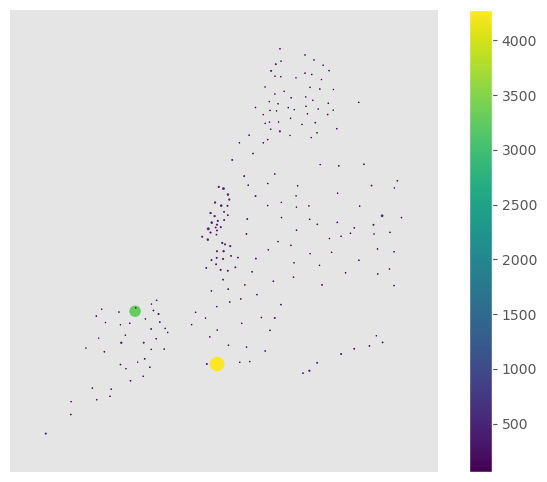

In [59]:
ax = gplt.pointplot(neighborhood_means_and_counts, scale='price', hue='price', limits=(0.5, 10), legend=True, projection=gcrs.AlbersEqualArea())


In [60]:
bx = gplt.choropleth(nyc_bubble_map, hue='neighbourhood', projection=gcrs.Robinson(), cmap='Oranges', legend=False)

C:\Users\Roger\anaconda3\lib\site-packages\geoplot\geoplot.py:708: UserWarning: Could not set plot extent successfully due to numerical instability. Try setting extent manually. Defaulting to a global extent.
  warnings.warn(


ValueError: Axis limits cannot be NaN or Inf

<Figure size 800x600 with 1 Axes>

AttributeError: 'Point' object has no attribute 'exterior'

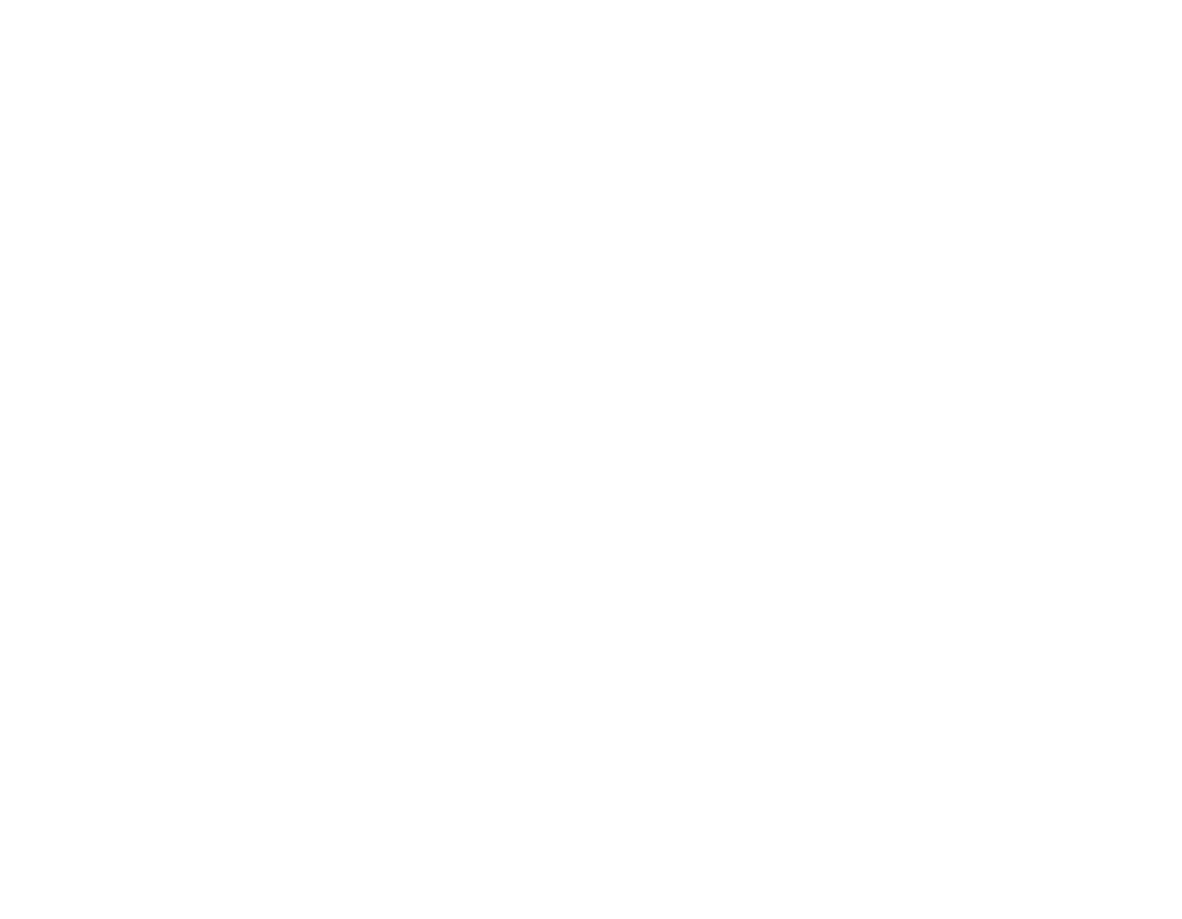

In [31]:
nyc_map_axis = gplt.polyplot(neighborhood_means_and_counts, facecolor="neighbourhood", alpha=0.1, figsize=(15, 15));
geoplot.pointplot(neighborhood_means_and_counts,
                  ax=nyc_map_axis,
                  color="tomato",
                  edgecolor="black",
                  alpha=0.5
                 );

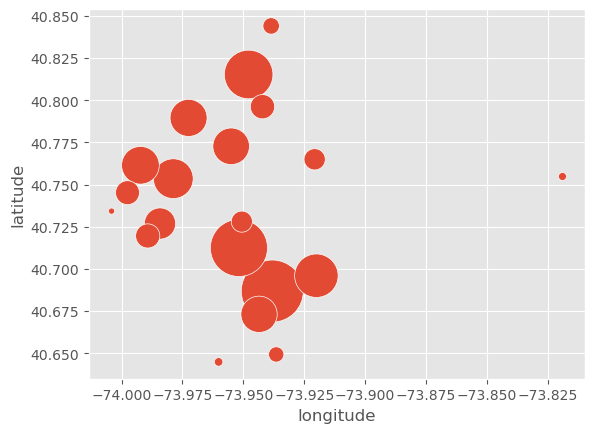

In [32]:
a = sns.scatterplot(data=neighborhood_means_and_counts.sort_values(by='neighborhood_count',ascending=False).head(20), x="longitude", y="latitude", size="neighborhood_count", legend=False, sizes=(20, 2000))

In [33]:
neighborhood_means_and_counts.sort_values(by='price',ascending=False).head(20)

,neighborhood_count,latitude,longitude,price,geometry
neighbourhood,,,,,
Coney Island,18,40.577128,-73.994464,4277.833333,POINT (-73.994 40.577)
West Brighton,23,40.631975,-74.113903,3263.521739,POINT (-74.114 40.632)
Tribeca,100,40.717744,-74.007508,531.580000,POINT (-74.008 40.718)
Hollis Hills,1,40.731190,-73.754120,484.000000,POINT (-73.754 40.731)
Theater District,184,40.759631,-73.985296,473.592391,POINT (-73.985 40.760)
Flatiron District,85,40.741899,-73.988540,419.223529,POINT (-73.989 40.742)
SoHo,195,40.724239,-74.002360,416.661538,POINT (-74.002 40.724)
Midtown,1188,40.753467,-73.978756,386.317340,POINT (-73.979 40.753)
Financial District,375,40.706557,-74.008102,375.013333,POINT (-74.008 40.707)


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

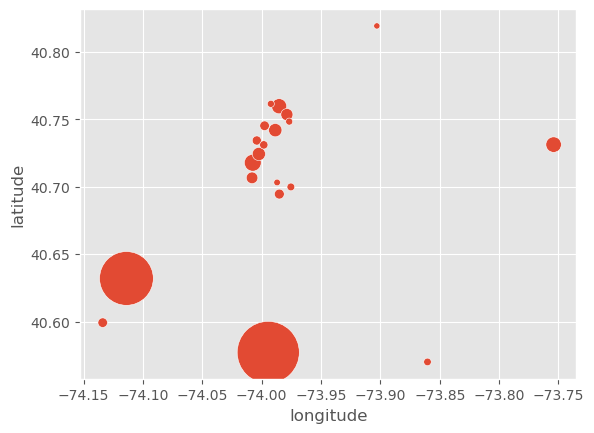

In [34]:
sns.scatterplot(data=neighborhood_means_and_counts.sort_values(by='price',ascending=False).head(20), x="longitude", y="latitude", size="price", legend=False, sizes=(20, 2000))

In [35]:
def get_outlier_bounds(col_name):
    '''
    Gets the bound for outliers in the dataset. This is to make the visualizations easier. This function is 
    specifically for this usage and dataset
     
    Param:
        col_name: the name of the column for which you want the bounds. Must be a numerical column
    Return:
        A tuple with the col_name, upper_bound and lower_bound
    '''
    iqr = describe_df.loc['75%',col_name] - describe_df.loc['25%',col_name]
    upper_bound = describe_df.loc['75%',col_name] + (1.5* iqr)
    lower_bound = describe_df.loc['25%',col_name] - (1.5*iqr)
    print(col_name)
    print('upper bound ' + upper_bound.astype(str))
    print('lower bound ' + lower_bound.astype(str))
    print('-'*50)
    return (col_name,upper_bound,lower_bound)

In [36]:
# filtering out the outliers
# We only want the numeric columns because the get_outlier_bounds won't work on strings
numeric_cols = listingsNYC.select_dtypes(include=np.number)
for column in numeric_cols.columns:
    listingsNYC = listingsNYC[(listingsNYC[column] < get_outlier_bounds(column)[1]) & (listingsNYC[column] > get_outlier_bounds(column)[2])]
listingsNYC

latitude
upper bound 40.876619999999996
lower bound 40.57166
--------------------------------------------------
latitude
upper bound 40.876619999999996
lower bound 40.57166
--------------------------------------------------
longitude
upper bound -73.83594000000002
lower bound -74.0685
--------------------------------------------------
longitude
upper bound -73.83594000000002
lower bound -74.0685
--------------------------------------------------
price
upper bound 400.0
lower bound -112.0
--------------------------------------------------
price
upper bound 400.0
lower bound -112.0
--------------------------------------------------
minimum_nights
upper bound 72.0
lower bound -40.0
--------------------------------------------------
minimum_nights
upper bound 72.0
lower bound -40.0
--------------------------------------------------
number_of_reviews
upper bound 85.5
lower bound -46.5
--------------------------------------------------
number_of_reviews
upper bound 85.5
lower bound -46.5
---

KeyError: 'log_price'